In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 데이터 이해 및 전처리

In [52]:
df = pd.read_csv('df_labeled.csv', index_col = 0).drop_duplicates()


In [53]:
df # = df.groupby(['Date', 'Press'])['Title', 'Change'].mean()

,Press,Date,Title,Change
0,연합뉴스,1998-05-20,주가 사흘째 상승세,0
1,연합뉴스,1998-05-20,"아남텔레콤, PDA 데이터 전송서비스 개시",0
2,연합뉴스,1998-05-20,"<회전목마> 삼성전자, 사이버 사외보 제작",0
3,연합뉴스,1998-05-20,"<주식시황> 사흘째 상승, 3백70선 다가서",0
4,연합뉴스,1998-05-20,"-춘계승마- 신창무,싼졸쥬마장마술 우승",0
...,...,...,...,...
3851965,한국경제,2022-07-21,"디지털이미지뱅크, 한투등 3개사서 20억원 투자 유치",1
3851966,한국경제,2022-07-21,[코스닥공시] 세보기계,1
3851967,한국경제,2022-07-21,전자.통신업체 신용등급도 급상승세,1
3851968,한국경제,2022-07-21,"종합주가 폭락세, 916.01(-37.21) 전장마감",1


In [54]:
df.Change.value_counts()

 1    1838065
-1    1707037
 0     130853
Name: Change, dtype: int64

In [55]:
df = df.drop(columns=['Press'])

In [56]:
df

,Date,Title,Change
0,1998-05-20,주가 사흘째 상승세,0
1,1998-05-20,"아남텔레콤, PDA 데이터 전송서비스 개시",0
2,1998-05-20,"<회전목마> 삼성전자, 사이버 사외보 제작",0
3,1998-05-20,"<주식시황> 사흘째 상승, 3백70선 다가서",0
4,1998-05-20,"-춘계승마- 신창무,싼졸쥬마장마술 우승",0
...,...,...,...
3851965,2022-07-21,"디지털이미지뱅크, 한투등 3개사서 20억원 투자 유치",1
3851966,2022-07-21,[코스닥공시] 세보기계,1
3851967,2022-07-21,전자.통신업체 신용등급도 급상승세,1
3851968,2022-07-21,"종합주가 폭락세, 916.01(-37.21) 전장마감",1


In [57]:
df = df.groupby(['Date','Change']).sum()

날짜와 변동을 기준으로 groupby

In [58]:
df=df.iloc[7:,:]    # '1995-05.28'일자부터 설정

In [59]:
df = df.reset_index()#.drop(columns=['index'])
df

,Date,Change,Title
0,1998-05-28,1,"주가 상승세 삼성전자, 하나더 판촉 확대실시 <주식시황> 주가 상승 3백20선 회복..."
1,1998-05-29,1,"< 6.4선거 이후의 과제 > ...(下) 대기업그룹별 현안 전자업계 수출드라이브,..."
2,1998-05-30,-1,"정보통신업계, `실직자를 잡아라' 주가 하락세 반전 삼성전자, 세계 공용 DVD 개..."
3,1998-06-01,-1,"<회전목마> 삼성전자, 인터넷잡지 창간 지난해 상장기업 수출 28.8% 증가 현대전..."
4,1998-06-02,-1,공장도價 과다 책정...소비자불신 초래 <약수터> 환경부 고위공직자 근무지이탈 말썽...
...,...,...,...
8685,2022-07-17,1,"安통산장관, 무역업계와 간담회 삼성전자, 인력재배치 작업 본격화 삼성전자,2백40만..."
8686,2022-07-18,1,"불경기에도 자동차.화장품 광고는 활발 <주식시황> 주가, 큰 폭 상승 삼성전자 정보..."
8687,2022-07-19,-1,"반도체 업체들, 보따리장사로 골머리 주가 이틀째 급상승 三星電子, 세계 최경량 PC..."
8688,2022-07-20,-1,"삼성전자 반도체 전문 서비스센터 개설 삼성전관, `6시그마운동' 설명회 개최 상장사..."


In [60]:
train_ratio = 0.8
train_range = int(len(df) * train_ratio)
train_range

6952

In [61]:
train_data = df[:train_range]
test_data = df[train_range:]

In [62]:
print(len(train_data), len(test_data))

6952 1738


## 데이터 정제하기

<AxesSubplot:>

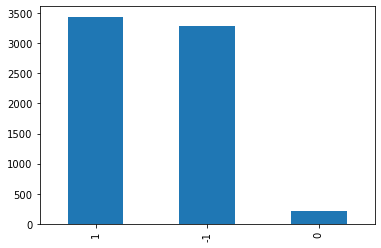

In [63]:
train_data.Change.value_counts().plot(kind = 'bar')

In [64]:
# Null값 확인
train_data.isnull().sum()

Date      0
Change    0
Title     0
dtype: int64

In [65]:
# 한글과 공백을 제외하고 모두 제거
train_data['Title'] = train_data['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/3310472941.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['Title'] = train_data['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/3310472941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Title'] = train_data['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,Date,Change,Title
0,1998-05-28,1,주가 상승세 삼성전자 하나더 판촉 확대실시 주식시황 주가 상승 백선 회복 특집 체...
1,1998-05-29,1,선거 이후의 과제 대기업그룹별 현안 전자업계 수출드라이브 해외서 견제 심해져 ...
2,1998-05-30,-1,정보통신업계 실직자를 잡아라 주가 하락세 반전 삼성전자 세계 공용 개발 주식시황 ...
3,1998-06-01,-1,회전목마 삼성전자 인터넷잡지 창간 지난해 상장기업 수출 증가 현대전자 메모리 반도...
4,1998-06-02,-1,공장도 과다 책정소비자불신 초래 약수터 환경부 고위공직자 근무지이탈 말썽 주가 큰 ...


In [66]:
# 한글이 없던 제목은 빈값이 됐을 것, Null로 변경
train_data['Title'] = train_data['Title'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['Title'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

# Null값 없음
# test_data = test_data.dropna(how='any') # Null 값 제거


/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/1348153231.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['Title'] = train_data['Title'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


Date      0
Change    0
Title     0
dtype: int64


/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/1348153231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Title'] = train_data['Title'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/1348153231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Title'].replace('', np.nan, inplace=True)


In [67]:
# 테스트 데이터도 같은 방식으로 전처리

test_data.drop_duplicates(subset = ['Title'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['Title'] = test_data['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['Title'] = test_data['Title'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['Title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/180619570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset = ['Title'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/180619570.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['Title'] = test_data['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


전처리 후 테스트용 샘플의 개수 : 1738


/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/180619570.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Title'] = test_data['Title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/180619570.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['Title'] = test_data['Title'].str.replace('^ +', "") # 공백은 empty 값으로 변경
/var/folders/1d/lfkpl6ps02xgh0rdprtbmgvw0000gn/T/ipykernel_3710/180619570.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

## 토큰화

In [68]:
# 불용어 설정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [70]:
# 토큰화를 위한 형태소 분석기, KoNLPy의 OKt 사용
okt = Okt()

X_train = []
for sentence in tqdm(train_data['Title']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████| 6952/6952 [22:00<00:00,  5.26it/s]


In [71]:
# 상위 3개 데이터 보기
print(X_train[:3])

[['주가', '상승세', '삼성', '전자', '하나', '더', '판촉', '확대', '실시', '주식', '시', '황', '주가', '상승', '백선', '회복', '특집', '체제', '개월', '기업', '구조조정'], ['선거', '이후', '과제', '대기업', '그룹', '별', '현안', '전자', '업계', '수출', '드라이브', '해외', '서', '견제', '심해지다', '주식', '시', '황주', '사흘', '째', '상승', '백선', '회복', '삼성', '전자', '급등', '그룹', '차원', '주가', '관리', '가능성'], ['정보', '통신업', '계', '실직자', '잡다', '주가', '하락', '세', '반전', '삼성', '전자', '세계', '공용', '개발', '주식', '시', '황', '주가', '일만', '하락', '세', '반전', '상무부', '국산', '컬러', '연례', '재심', '개시']]


In [73]:
X_train

[['주가',
  '상승세',
  '삼성',
  '전자',
  '하나',
  '더',
  '판촉',
  '확대',
  '실시',
  '주식',
  '시',
  '황',
  '주가',
  '상승',
  '백선',
  '회복',
  '특집',
  '체제',
  '개월',
  '기업',
  '구조조정'],
 ['선거',
  '이후',
  '과제',
  '대기업',
  '그룹',
  '별',
  '현안',
  '전자',
  '업계',
  '수출',
  '드라이브',
  '해외',
  '서',
  '견제',
  '심해지다',
  '주식',
  '시',
  '황주',
  '사흘',
  '째',
  '상승',
  '백선',
  '회복',
  '삼성',
  '전자',
  '급등',
  '그룹',
  '차원',
  '주가',
  '관리',
  '가능성'],
 ['정보',
  '통신업',
  '계',
  '실직자',
  '잡다',
  '주가',
  '하락',
  '세',
  '반전',
  '삼성',
  '전자',
  '세계',
  '공용',
  '개발',
  '주식',
  '시',
  '황',
  '주가',
  '일만',
  '하락',
  '세',
  '반전',
  '상무부',
  '국산',
  '컬러',
  '연례',
  '재심',
  '개시'],
 ['회전목마',
  '삼성',
  '전자',
  '인터넷',
  '잡지',
  '창간',
  '지난해',
  '상장',
  '기업',
  '수출',
  '증가',
  '현대',
  '전자',
  '메모리',
  '반도체',
  '본격',
  '감산',
  '돌입',
  '삼성',
  '전자',
  '포럼',
  '서울',
  '회의',
  '주최',
  '전자',
  '진흥',
  '회',
  '국내',
  '업계',
  '붕괴',
  '위기'],
 ['공장',
  '다',
  '책정',
  '소비자',
  '불신',
  '초래',
  '약수터',
  '환경부',
  '고위',
  '공직자',
  '근무',
  '지',
  '이탈

In [76]:
import pickle

with open('tokenizer.pickle','wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [77]:
with open('tokenizer.pickle', 'rb') as handle:
    X_train = pickle.load(handle)

In [72]:
# 테스트 데이터에 대해서도 동일하게 토큰화
X_test = []
for sentence in tqdm(test_data['Title']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

  1%|▍                                        | 21/1738 [00:13<17:45,  1.61it/s]


KeyboardInterrupt: 

## 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 단어 집합 생성과 함께 고유한 정수가 부여됨 / 등장 빈도수가 높은 순서대로 부여됨
print(tokenizer.word_index)

- 높은 점수 = 등장 빈도수 낮음

In [ ]:
# 등장 빈도수가 3회 미만인 단어들의 비중을 확인해보자

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

- 정수 인코딩 잘 됐는지 확인

In [ ]:
print(X_train[:3])

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

## 패딩

In [ ]:
print('제목의 최대 길이 :',max(len(review) for review in X_train))
print('제목의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
      for sentence in nested_list:
        if(len(sentence) <= max_len):
        count = count + 1
        print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
        

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# LSTM 활용

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

# 예측

- 현재 학습한 model에, 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용한다 
- model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()를 사용해야 한다

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))